In [1]:
!nvidia-smi

/bin/sh: nvidia-smi: command not found


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

### Testing Model, only using 2xzn for now

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import math
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.optim as optim
import numpy as np
import scipy.sparse as sp
import sklearn.metrics

In [5]:
AMINO_ACIDS = np.array(['ALA', 'CYS', 'ASP', 'GLU', 'PHE', 'GLY', 'HIS', 'ILE', 'LYS', 'LEU', 'MET', 'ASN', 'PRO', 'GLN', 'ARG'
               , 'SER','THR', 'VAL', 'TRP', 'TYR'])

In [6]:
"""
Layers of graph convolution
"""

class GClayer(Module):
    def __init__(self, nin, nout, bias = False):
        super(GClayer, self).__init__()
        self.in_features = nin
        self.out_features = nout
        self.weight = Parameter(torch.randn(nin, nout))
        
        if bias:
            self.bias = Parameter(torch.randn(out_features))
        else:
            self.register_parameter('bias', None)
        
    def forward(self, input, adj):
        temp = torch.mm(input, self.weight)
        output = torch.sparse.mm(adj, temp)
        if self.bias is not None:
            return output + self.bias
        else:
            return output
    
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)
    
    def __repr__(self):
        return self.__class__.__name__ + '(' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


In [7]:
"""
GCN model
"""

class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()
        
        self.gc1 = GClayer(nfeat, nhid)
        self.gc2 = GClayer(nhid, nclass)
        self.dropout = dropout
        
    def forward(self, x, adj):
        x = F.leaky_relu(self.gc1(x, adj))
        #x = F.dropout(x, self.dropout, training=self.training)
        x = F.leaky_relu(self.gc2(x, adj))
        return F.sigmoid(x)

In [8]:
from Bio.PDB import *

"""Get contact map of the structure, will be use as adjacency matrix"""
def getContactMap(p, path):
    parser = PDBParser()
    structure = parser.get_structure(p, path)[0]
    
    res_list = []
    
    p_chains = []
    for chain in structure:
        for residue in chain:
            if residue.get_resname() in AMINO_ACIDS:
                p_chains.append(chain)
                break
    
    c_map = []
    for chain in p_chains:
        for residue in chain:
            if residue.get_resname() not in AMINO_ACIDS: 
                continue
            
            res_list.append(residue.get_resname())
                
            temp = [] 
            counter = 0
            for c in p_chains:
                for r in c:
                    if r.get_resname() not in AMINO_ACIDS: 
                        continue
                    counter += 1
                    dis = np.linalg.norm(residue['CA'].get_coord() - r['CA'].get_coord())
                    if dis <= 7:
                        temp.append(1)
                    else:
                        temp.append(0)
            c_map.append(temp)

            
    return c_map, res_list

In [9]:
"""def loadData():"""
f = np.genfromtxt('./trial_data/2BU1.txt', dtype = np.dtype(str))


features = np.array(f[:, 1:-1], dtype = np.float32)
labels = np.array(f[:, -1], dtype = np.int_)
reses = f[:, 0]

contact_map, res_list = getContactMap('2BU1', '../datasets/Tongji/benchmark/pdb/2BU1.pdb')
adj = sp.coo_matrix(contact_map, dtype = 'int')

print(adj.shape)

(387, 387)


In [10]:
"""Laplacian Matrix"""
#def normalize(mx):
row_sum = np.array(adj.sum(1), dtype = np.float32)
r_inv = np.power(row_sum, -1).flatten()
r_inv[np.isinf(r_inv)] = 0
r_inv_mat = sp.diags(r_inv)
#norm_lap = sp.eye(adj.shape[0]) - r_inv_mat.dot(adj)
# this is wrong, the paper did not used laplacian graph
norm_lap = r_inv_mat.dot(adj)

# print("Inverse degree matrix: {}\n Normalized Laplacian: {}".format(r_inv_mat, norm_lap))

In [11]:
# min-max normalization for the features (bond to change a little)
for i in range(20, 24):
    features[:, i] = (features[:, i] - np.min(features[:, i])) / (np.max(features[:, i]) - np.min(features[:, i]))

In [12]:
"""
Converting sparse matrix to torch tensor
"""
def sparseToTensor(sp_mx):
    sp_mx = sp_mx.tocoo().astype(np.float32)
    #vertically stack row and column indices with non-zero value
    indices = torch.from_numpy(
        np.vstack((sp_mx.row, sp_mx.col)).astype(np.int_)) 
    values = torch.from_numpy(sp_mx.data)
    shape = torch.Size(sp_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [13]:
"""Turn everything into tensors (part of loadData())"""
temp = torch.LongTensor(range(adj.shape[0]))
temp_perm = temp[torch.randperm(adj.shape[0])]

train_idx_1 = temp_perm[:250]
val_idx_1 = temp_perm[250:300]
test_idx_1 = temp_perm[300:]

# print("Train index: {} \n Validation index: {} \n Test index: {}\n".format(train_idx_1, val_idx_1, test_idx_1))
# print("=========================================================================================================")

norm_lap_1 = sparseToTensor(norm_lap)
features_1 = torch.FloatTensor(features)
labels_1 = torch.LongTensor(labels)

# print("Labels: {}\n Features: {}\n Laplacia: {}".format(labels_1, features_1, norm_lap_1.to_dense())) #to_dense() shows the sparse matrix in regular dense format
#return adj, features, labels, train_idx, val_idx, test_idx

In [14]:
print(features_1)

tensor([[1.0000, 0.0000, 0.0000,  ..., 0.2981, 0.9956, 0.2574],
        [0.0000, 0.0000, 0.0000,  ..., 0.2287, 0.9969, 0.2371],
        [0.0000, 0.0000, 1.0000,  ..., 0.1785, 0.9980, 0.4304],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.8296, 0.0000, 0.0254],
        [0.0000, 0.0000, 0.0000,  ..., 0.8406, 0.9294, 0.5395],
        [0.0000, 0.0000, 0.0000,  ..., 0.9092, 0.9148, 1.0000]])


In [15]:
model = GCN(nfeat = features.shape[1],
            nhid = 12,
            nclass= 2,
            dropout = 0.5)
optimizer = optim.Adam(model.parameters(),
                       lr = 0.01, weight_decay = 5e-4)
print(model)

GCN(
  (gc1): GClayer(24 -> 12)
  (gc2): GClayer(12 -> 2)
)


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

In [17]:
 criterion = nn.CrossEntropyLoss()

In [18]:
if torch.cuda.is_available():
    model.to(device)
    features_1 = features_1.cuda()
    norm_lap_1 = norm_lap_1.cuda()
    labels_1 = labels_1.cuda()
    train_idx_1 = train_idx_1.cuda()
    val_idx_1 = val_idx_1.cuda()
    test_idx_1 = test_idx_1.cuda()

In [19]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [20]:
def train(epoch):
    t = time.time()
    
    model.train()
    optimizer.zero_grad()
    output = model(features_1, norm_lap_1)
    
    loss_train = criterion(output[train_idx_1], labels_1[train_idx_1])
    acc_train = accuracy(output[train_idx_1], labels_1[train_idx_1])
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    loss_val = criterion(output[val_idx_1], labels_1[val_idx_1])
    acc_val = accuracy(output[val_idx_1], labels_1[val_idx_1])
    
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    
    return loss_train, acc_train, loss_val, acc_val

In [21]:
list_loss_t, list_acc_t, list_loss_v, list_acc_v = [], [], [], []
for i in range(300):
    loss_train, acc_train, loss_val, acc_val = train(i)
    list_loss_t.append(loss_train)
    list_acc_t.append(acc_train)
    list_loss_v.append(loss_val)
    list_acc_v.append(acc_val)

Epoch: 0001 loss_train: 0.6981 acc_train: 0.5880 loss_val: 0.7075 acc_val: 0.5000 time: 0.0054s
Epoch: 0002 loss_train: 0.6905 acc_train: 0.6640 loss_val: 0.6997 acc_val: 0.5400 time: 0.0031s
Epoch: 0003 loss_train: 0.6823 acc_train: 0.7320 loss_val: 0.6930 acc_val: 0.6600 time: 0.0027s
Epoch: 0004 loss_train: 0.6733 acc_train: 0.7720 loss_val: 0.6844 acc_val: 0.7400 time: 0.0027s
Epoch: 0005 loss_train: 0.6639 acc_train: 0.8160 loss_val: 0.6745 acc_val: 0.8000 time: 0.0031s
Epoch: 0006 loss_train: 0.6540 acc_train: 0.8640 loss_val: 0.6647 acc_val: 0.8200 time: 0.0031s
Epoch: 0007 loss_train: 0.6436 acc_train: 0.8880 loss_val: 0.6543 acc_val: 0.9200 time: 0.0026s
Epoch: 0008 loss_train: 0.6335 acc_train: 0.9040 loss_val: 0.6429 acc_val: 0.9600 time: 0.0029s
Epoch: 0009 loss_train: 0.6239 acc_train: 0.9160 loss_val: 0.6307 acc_val: 0.9400 time: 0.0028s
Epoch: 0010 loss_train: 0.6147 acc_train: 0.9280 loss_val: 0.6191 acc_val: 0.9200 time: 0.0032s
Epoch: 0011 loss_train: 0.6059 acc_train

Epoch: 0103 loss_train: 0.5073 acc_train: 0.9320 loss_val: 0.5029 acc_val: 0.9400 time: 0.0027s
Epoch: 0104 loss_train: 0.5072 acc_train: 0.9320 loss_val: 0.5029 acc_val: 0.9400 time: 0.0027s
Epoch: 0105 loss_train: 0.5072 acc_train: 0.9320 loss_val: 0.5029 acc_val: 0.9400 time: 0.0025s
Epoch: 0106 loss_train: 0.5071 acc_train: 0.9320 loss_val: 0.5028 acc_val: 0.9400 time: 0.0023s
Epoch: 0107 loss_train: 0.5071 acc_train: 0.9320 loss_val: 0.5028 acc_val: 0.9400 time: 0.0024s
Epoch: 0108 loss_train: 0.5070 acc_train: 0.9320 loss_val: 0.5027 acc_val: 0.9400 time: 0.0023s
Epoch: 0109 loss_train: 0.5070 acc_train: 0.9320 loss_val: 0.5027 acc_val: 0.9400 time: 0.0024s
Epoch: 0110 loss_train: 0.5070 acc_train: 0.9320 loss_val: 0.5027 acc_val: 0.9400 time: 0.0037s
Epoch: 0111 loss_train: 0.5069 acc_train: 0.9320 loss_val: 0.5026 acc_val: 0.9400 time: 0.0030s
Epoch: 0112 loss_train: 0.5069 acc_train: 0.9320 loss_val: 0.5026 acc_val: 0.9400 time: 0.0028s
Epoch: 0113 loss_train: 0.5068 acc_train

Epoch: 0189 loss_train: 0.5044 acc_train: 0.9320 loss_val: 0.5001 acc_val: 0.9400 time: 0.0029s
Epoch: 0190 loss_train: 0.5043 acc_train: 0.9320 loss_val: 0.5001 acc_val: 0.9400 time: 0.0026s
Epoch: 0191 loss_train: 0.5043 acc_train: 0.9320 loss_val: 0.5001 acc_val: 0.9400 time: 0.0024s
Epoch: 0192 loss_train: 0.5043 acc_train: 0.9320 loss_val: 0.5001 acc_val: 0.9400 time: 0.0029s
Epoch: 0193 loss_train: 0.5043 acc_train: 0.9320 loss_val: 0.5000 acc_val: 0.9400 time: 0.0029s
Epoch: 0194 loss_train: 0.5042 acc_train: 0.9320 loss_val: 0.5000 acc_val: 0.9400 time: 0.0026s
Epoch: 0195 loss_train: 0.5042 acc_train: 0.9320 loss_val: 0.5000 acc_val: 0.9400 time: 0.0026s
Epoch: 0196 loss_train: 0.5042 acc_train: 0.9320 loss_val: 0.4999 acc_val: 0.9400 time: 0.0025s
Epoch: 0197 loss_train: 0.5041 acc_train: 0.9320 loss_val: 0.4999 acc_val: 0.9400 time: 0.0024s
Epoch: 0198 loss_train: 0.5041 acc_train: 0.9320 loss_val: 0.4999 acc_val: 0.9400 time: 0.0027s
Epoch: 0199 loss_train: 0.5041 acc_train

Epoch: 0288 loss_train: 0.5015 acc_train: 0.9320 loss_val: 0.4972 acc_val: 0.9400 time: 0.0024s
Epoch: 0289 loss_train: 0.5014 acc_train: 0.9320 loss_val: 0.4971 acc_val: 0.9400 time: 0.0023s
Epoch: 0290 loss_train: 0.5014 acc_train: 0.9320 loss_val: 0.4971 acc_val: 0.9400 time: 0.0022s
Epoch: 0291 loss_train: 0.5014 acc_train: 0.9320 loss_val: 0.4971 acc_val: 0.9400 time: 0.0024s
Epoch: 0292 loss_train: 0.5013 acc_train: 0.9320 loss_val: 0.4970 acc_val: 0.9400 time: 0.0025s
Epoch: 0293 loss_train: 0.5013 acc_train: 0.9320 loss_val: 0.4970 acc_val: 0.9400 time: 0.0025s
Epoch: 0294 loss_train: 0.5013 acc_train: 0.9320 loss_val: 0.4970 acc_val: 0.9400 time: 0.0027s
Epoch: 0295 loss_train: 0.5012 acc_train: 0.9320 loss_val: 0.4969 acc_val: 0.9400 time: 0.0023s
Epoch: 0296 loss_train: 0.5012 acc_train: 0.9320 loss_val: 0.4969 acc_val: 0.9400 time: 0.0024s
Epoch: 0297 loss_train: 0.5012 acc_train: 0.9320 loss_val: 0.4969 acc_val: 0.9400 time: 0.0022s
Epoch: 0298 loss_train: 0.5011 acc_train

Text(0.5, 1.0, 'Validation Accuracy')

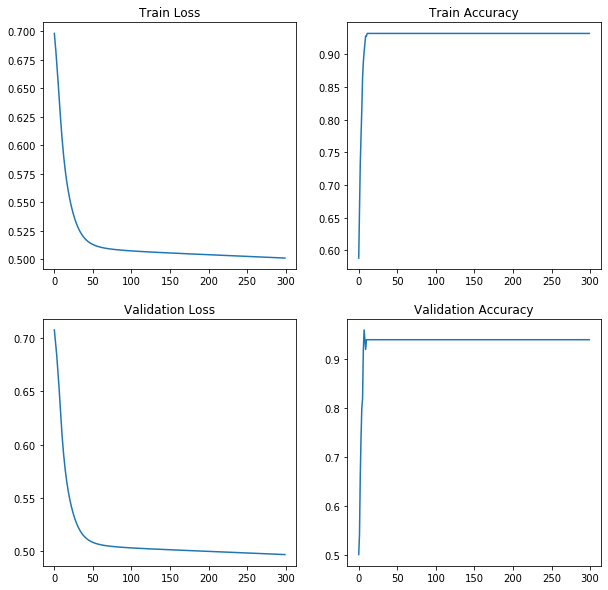

In [22]:
epochs = range(300)
f, axes = plt.subplots(2, 2, figsize = (10,10))
axes[0, 0].plot(epochs, list_loss_t)
axes[0, 0].set_title("Train Loss")
axes[0, 1].plot(epochs, list_acc_t)
axes[0, 1].set_title("Train Accuracy")
axes[1, 0].plot(epochs, list_loss_v)
axes[1, 0].set_title("Validation Loss")
axes[1, 1].plot(epochs, list_acc_v)
axes[1, 1].set_title("Validation Accuracy")

In [23]:
# def test():
model.eval()
output = model(features_1, norm_lap_1)
loss_test = F.nll_loss(output[test_idx_1], labels_1[test_idx_1])
acc_test = accuracy(output[test_idx_1], labels_1[test_idx_1])
print("Test set results:",
      "loss= {:.4f}".format(loss_test.item()),
      "accuracy= {:.4f}".format(acc_test.item()))

Test set results: loss= -0.9621 accuracy= 0.9310


In [24]:
print(F.softmax(output))

tensor([[0.6252, 0.3748],
        [0.6253, 0.3747],
        [0.6256, 0.3744],
        [0.6255, 0.3745],
        [0.6252, 0.3748],
        [0.6247, 0.3753],
        [0.6251, 0.3749],
        [0.6247, 0.3753],
        [0.6255, 0.3745],
        [0.6250, 0.3750],
        [0.6244, 0.3756],
        [0.6209, 0.3791],
        [0.6198, 0.3802],
        [0.6190, 0.3810],
        [0.6190, 0.3810],
        [0.6200, 0.3800],
        [0.6221, 0.3779],
        [0.6242, 0.3758],
        [0.6246, 0.3754],
        [0.6249, 0.3751],
        [0.6249, 0.3751],
        [0.6247, 0.3753],
        [0.6247, 0.3753],
        [0.6235, 0.3765],
        [0.6225, 0.3775],
        [0.6224, 0.3776],
        [0.6222, 0.3778],
        [0.6223, 0.3777],
        [0.6232, 0.3768],
        [0.6242, 0.3758],
        [0.6244, 0.3756],
        [0.6251, 0.3749],
        [0.6254, 0.3746],
        [0.6256, 0.3744],
        [0.6263, 0.3737],
        [0.6267, 0.3733],
        [0.6272, 0.3728],
        [0.6270, 0.3730],
        [0.6

In [25]:
output.max(1)[1]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

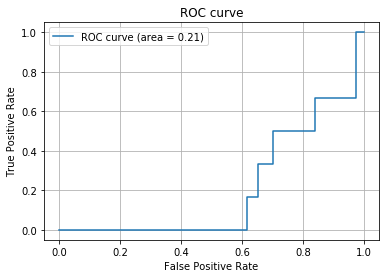

In [26]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(labels_1[test_idx_1].cpu().tolist(), output[test_idx_1].max(1)[0].cpu().tolist())

auc = sklearn.metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)